# PPG Field Study Dataset

The main purpose of the dataset is PPG-based heart rate estimation. Three sensor modalities are used: 
1. the PPG-sensor itself
2. 3D-accelerometer embedded in the same device as the PPG-sensor, used to compensate motion artefacts
3. ECG which provides heart rate ground truth.

All data signal is segmented with the sliding window approach (window length: 8 seconds, window shift: 2 seconds), and the goal is to determine the heart rate on each 8-second window segment.


15 subjects participated in the study, seven male and eight female subjects, aged 30.60 ± 9.59 years. The dataset is organised so that each subject has a folder (SX, where X = subject ID). Each subject folder contains the following files:
 - SX_quest.csv: contains information about the subject; see details below
 - SX_activity.csv: contains the activity labels; time is given in seconds and refers to the time when the respective activity started
 - SX_RespiBAN.h5: contains data from the RespiBAN device; see details below
 - SX_E4.zip: contains data from the Empatica E4 device; see details below
 - SX.pkl: contains synchronised data and labels; see details below
 
Information on each subject can be found in SX_quest.csv. The following information is provided there:
- age (years)
- gender
- height (cm)
- weight (kg)
- skin type (according to the Fitzpatrick scale [2])
- fitness level (how often does the subject do sports; on a scale 1-6 where 1 refers to less than once a month and 6 refers to 5-7 times a week

## Data collection protocol

Each subject followed a defined data collection protocol, including eight different activities. Subjects were instructed to carry out the activities as naturally as possible. The following list provides details on each of the activities, including the activity ID used in the final data structure (see III.3. below):
- **Sitting (ID: 1):** Sitting still while reading. The aim of this activity was to generate a motionartefact-free baseline.
- **Ascending and descending stairs (ID: 2):** Climbing six floors up and going down again, repeating this twice. This activity was carried out in the main building at our research campus. Note: for subjects S1 and S2, going down was performed only once.
- **Table soccer (ID: 3):** Playing table soccer, 1 vs. 1 with the supervisor of the data collection.
- **Cycling (ID: 4):** Performed outdoors, around our research campus, following a defined route of about 2km length with varying road conditions (gravel, paved).
- **Driving a car (ID: 5):** This activity started at the parking ground of our research campus and was carried out within the area nearby. Subjects followed a defined route which took about 15 minutes to complete. The route included driving on different streets in a small city as well as driving on country roads.
- **Lunch break (ID: 6):** This activity was carried out at the canteen of our research campus. The activity included queuing and fetching food, eating, and talking at the table.
- **Walking (ID: 7):** This activity was carried out within the premises of our research campus, walking back from the canteen to the office, with some detour.
- **Working (ID: 8):** Subjects returned to their desk and worked as if not participating in this study. For each subject, work mainly consisted of working on a computer

## Data format

Raw sensor data was recorded with two devices: a chest-worn device (RespiBAN Professional, [3]) and a wrist-worn device (Empatica E4, [4]). The activity labels (see Section II above) are synchronised with the RespiBAN raw data (same start time). However, the RespiBAN and the Empatica E4 data need to be manually synchronised. Subjects performed a double tap gesture with their non-dominant hand (where they wore the E4) on their chest. The double tap gesture was performed both at the beginning and at the end of the data collection. The resulting characteristic pattern in the acceleration signal can be used for synchronising the two devices’ data. Moreover, the dataset also includes the file SX.pkl, which includes synchronised raw sensor data and labels.

### Data from RespiBAN

The RespiBAN Professional was used, with the following sensor modalities: ECG, respiration, and three-axis accelerometer. All signals were sampled at 700 Hz.

### Data from Empatica E4

The E4 was worn on the subjects’ non-dominant wrist. Sampling rate of the different sensors was different, as seen below:
- ACC.csv: sampled at 32 Hz. The 3 data columns refer to the 3 accelerometer channels. Data is provided in units of 1/64g.
- BVP.csv: sampled at 64 Hz. Data from photoplethysmograph (PPG).
- EDA.csv: sampled at 4 Hz. Data is provided in μS.
- TEMP.csv: sampled at 4 Hz. Data is provided in °C.

## Data synchronisation and labelling

**Synchronisation:** The double-tap signal pattern was used to manually synchronise the two devices’ raw data. Synchronisation was performed in two steps. First, the double-tap at the beginning of the data collection was used to align the start time of the two devices. Second, the double-tap at the end of the data collection was used to correct time drift.

**Data labelling:** an R-peak detector was used. The identified R-peaks were then manually inspected and corrected if required. This was necessary in a few cases for each subject, due to severe motion artefacts on the ECG-signal. Based on the identified and corrected R-peaks, the instantaneous heart rate was computed. Finally, the ECG-signal was segmented with a shifted window approach (window length: 8 seconds, window shift: 2 seconds). Ground truth heart rate is then defined as the mean instantaneous heart rate within each 8-second window. Applying a sliding window with 8/2 seconds is common practice in the literature of PPG-based heart rate estimation.


* Within SX.pkl, ‘data’ -> ‘label’ includes the heart rate ground truth for the 8-second segments, shifted with 2-seconds (the labels were extracted from the ECG-signal).
* Within SX.pkl, ‘data’ -> ‘signal’ -> ‘wrist’ -> ‘BVP’ includes the PPG-signal. The sampling rate is 64 Hz. This signal should be segmented with the same sliding window (8/2 seconds) to get the same time segments as the ground truth is provided for
* Within SX.pkl, ‘data’ -> ‘signal’ -> ‘wrist’ -> ‘ACC’ includes the ACC-signal. The sampling rate is 32 Hz. This signal should be segmented with the same sliding window (8/2 seconds) as the ground truth and the PPG-signal.

## Data dictionary

* **TEMP:** Data from temperature sensor expressed degrees on the Celsius (°C) scale.
* **ACC:** Data from 3-axis accelerometer sensor. Configured to measure acceleration in the range [-2g, 2g]. Therefore the unit is 1/64g. The sampling rate is 32 Hz. This signal should be segmented with the same sliding window (8/2 seconds) as the ground truth and the PPG-signal
* **BVP:** Data from photoplethysmograph. The sampling rate is 64 Hz. This signal should be segmented with the same sliding window (8/2 seconds) to get the same time segments as the ground truth is provided for.
* **label:** e heart rate ground truth for the 8-second segments, shifted with 2-seconds (the labels were extracted from the ECG-signal).

In [52]:
# Import
import pandas as pd
import numpy as np
import math
import os # for file handling
import matplotlib.pyplot as plt
%matplotlib inline

### Subject 7 data handling

In [216]:
# Import pickle and open Subject 7 file
# using 'latin1' encoding to pickled objects
import pickle

with open('../ppg_heart_rate_estimation/Subjects/S7/S7.pkl', 'rb') as f:
    x = pickle.load(f, encoding='latin1')

In [218]:
#length of ppg data
ppg_data = x['signal']['wrist']['BVP']
ppg_len = len(ppg_data)
ppg_data

array([[-45.17],
       [-50.1 ],
       [-54.31],
       ...,
       [ 41.96],
       [ 39.99],
       [ 38.71]])

In [220]:
#length of acc data
acc_data = x['signal']['wrist']['ACC']
acc_len = len(acc_data)

In [222]:
#length of acc data
temp_data = x['signal']['wrist']['TEMP']
temp_len = len(temp_data)

In [224]:
column_ppg = (ppg_len * 4) / (8*64)
column_ppg, ppg_len

(4671.5, 597952)

In [226]:
column_acc = acc_len/ (32 * 8) * 4
column_acc

4671.5

In [228]:
temp_data = x['signal']['wrist']['TEMP']
column_temp = len(temp_data) / (4*8) *4
column_temp

4671.5

In [230]:
# length of label data
label_data = x['label']
label_len = len(label_data)
column_label = label_len
label_len

4668

In [232]:
# Acc len -> the length is 298976, so if we calculate [acc_len / (8 seconds * 64 hertz) * 4 overlap/shift] we have = 4671.5 samples 
# (i.e., 4671.5 amounts of 8 seconds samples -> values in 8 seconds)

# the 4 overlap/shift happens because in 8 seconds you will switch to the right 4 times
# Jorn gave an example saying that the whole data will be basically a line where you cannot see the labels from far away because it's too big
# but if you zoom in you can see the 8 seconds sample and check the vector (values) in it
# if you slide to the right, u'll slide 2 seconds, thus not seeing the first 2 elements from before

# so i have to create vectors containing the 512 ppg values in 8 seconds, the [256 * 3 channels] acc values in 8 seconds, the 132 temperature values in 8 seconds and 1 label value in 8 seconds giving a total of 1413 columns  


# Temp has 4 Hz, that is, 4 values for 1 second, but as we want 8 seconds so it'll be [4 * 8] = 32 values in 8 seconds 

In [234]:
upd = {}
for k in x["signal"]["wrist"].keys():
    upd[k] = [a[0] for a in x["signal"]["wrist"][k]]
one_dim_ppg = upd['BVP']
len(one_dim_ppg)

597952

In [236]:
ppg_data[-1]

array([38.71])

In [238]:
one_dim_ppg[-1]

38.71

In [240]:
chunk_size_ppg = 512

df_ppg = pd.DataFrame()

for i in range(0, len(one_dim_ppg), chunk_size_ppg):
    chunk = one_dim_ppg[i:i+chunk_size_ppg]
    df_ppg = pd.concat([df_ppg, pd.DataFrame([chunk])], ignore_index=True)

# Display the DataFrame
# print(df)
df_ppg

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-45.17,-50.10,-54.31,-57.82,-61.00,-64.49,-68.99,-74.96,-82.30,-90.15,...,-348.63,-349.59,-343.19,-327.28,-300.43,-262.76,-216.13,-163.90,-110.10,-58.53
1,-11.97,28.01,60.98,87.39,108.25,124.95,138.84,151.07,162.08,171.61,...,43.97,33.60,23.23,13.49,4.99,-1.79,-6.69,-9.85,-11.76,-12.98
2,-14.08,-15.39,-16.98,-18.74,-20.45,-21.97,-23.26,-24.52,-26.06,-28.34,...,8.66,7.84,6.20,3.82,0.94,-2.09,-4.98,-7.56,-9.80,-11.79
3,-13.74,-15.90,-18.60,-22.08,-26.38,-31.12,-35.59,-38.88,-40.08,-38.63,...,-196.91,-200.54,-198.66,-188.87,-168.45,-135.25,-88.55,-29.56,38.37,109.90
4,177.98,234.56,272.08,285.36,273.28,239.54,191.60,138.29,87.13,42.71,...,-18.36,-22.43,-25.39,-26.77,-26.38,-24.59,-22.32,-20.83,-21.19,-23.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,31.95,32.98,34.48,36.06,37.20,37.38,36.27,33.82,30.22,25.83,...,54.56,53.28,52.55,52.49,53.09,54.16,55.38,56.27,56.31,55.05
1164,52.25,48.06,42.95,37.54,32.39,27.78,23.62,19.56,15.20,10.28,...,19.55,34.81,45.99,53.42,57.66,59.38,59.28,58.01,56.15,54.13
1165,52.20,50.48,48.95,47.61,46.46,45.61,45.22,45.44,46.30,47.64,...,36.42,33.05,29.81,26.86,24.12,21.30,18.18,14.68,10.99,7.51
1166,4.60,2.43,0.89,-0.31,-1.57,-3.13,-5.05,-7.27,-9.62,-11.98,...,84.30,78.02,65.68,46.53,21.42,-7.00,-34.99,-59.01,-77.03,-89.10


In [242]:
df_ppg.shape

(1168, 512)

In [244]:
one_dim_acc = upd['ACC']
len(one_dim_acc)

298976

In [246]:
acc_data

array([[-0.921875, -0.109375, -0.25    ],
       [-0.921875, -0.140625, -0.265625],
       [-0.953125, -0.171875, -0.265625],
       ...,
       [-0.59375 , -0.1875  ,  0.765625],
       [-0.46875 , -0.1875  ,  0.8125  ],
       [-0.453125, -0.1875  ,  0.84375 ]])

In [248]:
df_acc = pd.DataFrame()
chunk_size_acc = 256

for i in range(0, len(one_dim_acc), chunk_size_acc):
    chunk_acc = one_dim_acc[i:i+chunk_size_acc]
    df_acc = pd.concat([df_acc, pd.DataFrame([chunk_acc])], ignore_index=True)

df_acc

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.921875,-0.921875,-0.953125,-0.984375,-0.968750,-0.968750,-0.968750,-0.937500,-0.953125,-0.937500,...,-0.765625,-0.781250,-0.781250,-0.781250,-0.781250,-0.781250,-0.765625,-0.781250,-0.765625,-0.765625
1,-0.781250,-0.765625,-0.765625,-0.765625,-0.781250,-0.765625,-0.765625,-0.765625,-0.765625,-0.765625,...,-1.078125,-1.078125,-0.984375,-0.890625,-0.859375,-0.812500,-0.828125,-0.812500,-0.765625,-0.765625
2,-0.734375,-0.687500,-0.656250,-0.625000,-0.609375,-0.625000,-0.640625,-0.609375,-0.609375,-0.593750,...,-0.968750,-0.984375,-0.984375,-0.968750,-0.984375,-0.984375,-0.968750,-0.984375,-0.984375,-0.968750
3,-0.968750,-0.968750,-0.968750,-0.968750,-0.968750,-0.968750,-0.968750,-0.968750,-0.953125,-0.953125,...,-0.859375,-0.875000,-0.875000,-0.859375,-0.890625,-0.875000,-0.859375,-0.890625,-0.937500,-0.890625
4,-0.890625,-0.906250,-0.906250,-0.875000,-0.875000,-0.906250,-0.921875,-0.890625,-0.921875,-0.906250,...,-0.156250,-0.171875,-0.171875,-0.187500,-0.203125,-0.203125,-0.171875,-0.171875,-0.171875,-0.156250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,-0.656250,-0.656250,-0.656250,-0.656250,-0.656250,-0.656250,-0.656250,-0.656250,-0.656250,-0.656250,...,-0.656250,-0.656250,-0.656250,-0.656250,-0.656250,-0.656250,-0.656250,-0.656250,-0.656250,-0.656250
1164,-0.671875,-0.656250,-0.656250,-0.656250,-0.671875,-0.656250,-0.656250,-0.656250,-0.656250,-0.656250,...,-0.671875,-0.750000,-0.718750,-0.687500,-0.640625,-0.656250,-0.625000,-0.640625,-0.656250,-0.718750
1165,-0.796875,-0.781250,-0.656250,-0.640625,-0.687500,-0.671875,-0.671875,-0.671875,-0.656250,-0.671875,...,-0.906250,-0.921875,-0.921875,-0.906250,-0.890625,-0.906250,-0.890625,-0.890625,-0.890625,-0.890625
1166,-0.890625,-0.890625,-0.890625,-0.906250,-0.906250,-0.906250,-0.890625,-0.890625,-0.890625,-0.890625,...,-0.953125,-0.953125,-0.937500,-0.921875,-0.953125,-0.953125,-0.921875,-0.937500,-0.937500,-0.937500


In [250]:
df_acc.shape

(1168, 256)

In [252]:
len(upd['TEMP'])

37372

In [254]:
one_dim_temp = upd['TEMP']
one_dim_temp

[30.57,
 30.57,
 30.57,
 30.57,
 30.59,
 30.59,
 30.59,
 30.59,
 30.59,
 30.59,
 30.59,
 30.59,
 30.57,
 30.57,
 30.57,
 30.57,
 30.59,
 30.59,
 30.59,
 30.59,
 30.59,
 30.59,
 30.59,
 30.59,
 30.57,
 30.57,
 30.57,
 30.57,
 30.63,
 30.63,
 30.63,
 30.63,
 30.61,
 30.61,
 30.61,
 30.61,
 30.63,
 30.63,
 30.63,
 30.63,
 30.61,
 30.61,
 30.61,
 30.61,
 30.63,
 30.63,
 30.63,
 30.63,
 30.63,
 30.63,
 30.63,
 30.63,
 30.65,
 30.65,
 30.65,
 30.65,
 30.63,
 30.63,
 30.63,
 30.63,
 30.63,
 30.63,
 30.63,
 30.63,
 30.61,
 30.61,
 30.61,
 30.61,
 30.63,
 30.63,
 30.63,
 30.63,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.63,
 30.63,
 30.63,
 30.63,
 30.63,
 30.63,
 30.63,
 30.63,
 30.61,
 30.61,
 30.61,
 30.61,
 30.61,
 30.61,
 30.61,
 30.61,
 30.65,
 30.65,
 30.65,
 30.65,
 30.63,
 30.63,
 30.63,
 30.63,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.65,
 30.67,


In [39]:
df_temp = pd.DataFrame()
chunk_size_temp = 32

for i in range(0, len(one_dim_temp), chunk_size_temp):
    chunk_temp = one_dim_temp[i:i+chunk_size_temp]
    df_temp = pd.concat([df_temp, pd.DataFrame([chunk_temp])], ignore_index=True)

df_temp

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,30.57,30.57,30.57,30.57,30.59,30.59,30.59,30.59,30.59,30.59,...,30.59,30.59,30.57,30.57,30.57,30.57,30.63,30.63,30.63,30.63
1,30.61,30.61,30.61,30.61,30.63,30.63,30.63,30.63,30.61,30.61,...,30.65,30.65,30.63,30.63,30.63,30.63,30.63,30.63,30.63,30.63
2,30.61,30.61,30.61,30.61,30.63,30.63,30.63,30.63,30.65,30.65,...,30.63,30.63,30.61,30.61,30.61,30.61,30.61,30.61,30.61,30.61
3,30.65,30.65,30.65,30.65,30.63,30.63,30.63,30.63,30.65,30.65,...,30.65,30.65,30.65,30.65,30.65,30.65,30.67,30.67,30.67,30.67
4,30.69,30.69,30.69,30.69,30.67,30.67,30.67,30.67,30.69,30.69,...,30.67,30.67,30.69,30.69,30.69,30.69,30.71,30.71,30.71,30.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,34.57,34.57,34.57,34.57,34.55,34.55,34.55,34.55,34.55,34.55,...,34.59,34.59,34.57,34.57,34.57,34.57,34.55,34.55,34.55,34.55
1164,34.57,34.57,34.57,34.57,34.57,34.57,34.57,34.57,34.57,34.57,...,34.57,34.57,34.57,34.57,34.57,34.57,34.59,34.59,34.59,34.59
1165,34.57,34.57,34.57,34.57,34.59,34.59,34.59,34.59,34.57,34.57,...,34.57,34.57,34.57,34.57,34.57,34.57,34.55,34.55,34.55,34.55
1166,34.57,34.57,34.57,34.57,34.57,34.57,34.57,34.57,34.57,34.57,...,34.57,34.57,34.59,34.59,34.59,34.59,34.57,34.57,34.57,34.57


In [256]:
len(x['label'])

4668

In [41]:
df_label = pd.DataFrame()
chunk_size_label = 4

for i in range(0, label_len, chunk_size_label):
    chunk_label = label_data[i:i+chunk_size_label]
    df_label = pd.concat([df_label, pd.DataFrame([chunk_label])], ignore_index=True)

df_label

,0,1,2,3
0,54.717641,55.173302,55.393087,56.753642
1,60.946226,68.682777,72.557465,75.753724
2,77.049081,79.322851,81.168586,78.764942
3,75.616308,69.777059,66.318680,68.249640
4,67.168272,68.567345,65.725491,63.826549
...,...,...,...,...
1162,70.262647,68.674967,69.097695,70.841780
1163,67.749385,65.573028,65.373414,65.444687
1164,65.205569,66.736898,70.811880,77.277686
1165,83.472526,88.782974,91.514070,92.049333


In [42]:
# create a DataFrame
ddddf = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})

# create a list of new rows
new_rows = [{'A': 7, 'B': 8}, {'A': 9, 'B': 10}]

# append the new rows to the DataFrame
new_df = pd.concat([ddddf, pd.DataFrame([new_rows])], ignore_index=True)

print(new_df)

     A    B                 0                  1
0  1.0  4.0               NaN                NaN
1  2.0  5.0               NaN                NaN
2  3.0  6.0               NaN                NaN
3  NaN  NaN  {'A': 7, 'B': 8}  {'A': 9, 'B': 10}


In [258]:
label_data

array([54.71764132, 55.17330165, 55.39308696, ..., 86.94697029,
       79.71681682, 76.35414083])

In [260]:
len(upd['ACC'])/len(upd['TEMP'])

8.0

In [262]:
len(upd['ACC'])/256*4

4671.5

In [264]:
len(upd['ACC'])

298976

In [266]:
len(upd['BVP'])/len(x['label'])

128.09597257926308

In [268]:
upd['BVP']

[-45.17,
 -50.1,
 -54.31,
 -57.82,
 -61.0,
 -64.49,
 -68.99,
 -74.96,
 -82.3,
 -90.15,
 -96.88,
 -100.43,
 -98.92,
 -91.3,
 -77.77,
 -59.87,
 -39.95,
 -20.49,
 -3.4,
 10.34,
 20.65,
 28.03,
 33.18,
 36.75,
 39.24,
 41.01,
 42.33,
 43.43,
 44.39,
 45.25,
 45.92,
 46.33,
 46.49,
 46.47,
 46.46,
 46.66,
 47.25,
 48.21,
 49.37,
 50.37,
 50.82,
 50.43,
 49.09,
 46.89,
 44.05,
 40.78,
 37.28,
 33.68,
 30.02,
 26.39,
 22.87,
 19.55,
 16.48,
 13.66,
 11.04,
 8.53,
 6.04,
 3.5,
 0.91,
 -1.74,
 -4.35,
 -6.85,
 -9.22,
 -11.52,
 -13.94,
 -16.72,
 -20.12,
 -24.3,
 -29.25,
 -34.74,
 -40.41,
 -45.81,
 -50.58,
 -54.59,
 -57.97,
 -61.15,
 -64.74,
 -69.3,
 -75.0,
 -81.42,
 -87.33,
 -90.98,
 -90.46,
 -84.39,
 -72.45,
 -55.55,
 -35.66,
 -15.14,
 3.84,
 19.83,
 32.22,
 41.12,
 47.06,
 50.74,
 52.84,
 53.96,
 54.59,
 55.07,
 55.52,
 55.86,
 55.93,
 55.5,
 54.52,
 53.09,
 51.48,
 50.0,
 48.92,
 48.33,
 48.1,
 47.92,
 47.45,
 46.38,
 44.61,
 42.21,
 39.36,
 36.29,
 33.16,
 30.04,
 26.93,
 23.78,
 20.55,
 17.2

In [270]:
len(upd['BVP'])

597952

In [272]:
df = pd.DataFrame(upd)

ValueError: All arrays must be of the same length

In [274]:
ppg_data, len(ppg_data)

(array([[-45.17],
        [-50.1 ],
        [-54.31],
        ...,
        [ 41.96],
        [ 39.99],
        [ 38.71]]),
 597952)

In [ ]:
# how many data points in 1 seconds? 64 [Hz]
# how many data points in 8 seconds? [64 datapoints in 1 second * 8 seconds = 512]
# how many 8-second samples in total:
len(ppg_data) / (64 * 8)

In [65]:
# Assuming your two-dimensional array is 'two_dim_array'
two_dim_array = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Remove the second dimension and create a one-dimensional array
one_dim_array = two_dim_array.ravel()

# Now 'one_dim_array' is a one-dimensional array
two_dim_array

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [67]:
# POC - proof of concept

# ppg array (total length of 597952)
array_of_numbers = [i for i in range(37372)]

# Window length and shift
window_length = 8
window_shift = 2

# List to store the chunks
chunks = []

poc_df = pd.DataFrame()

# Iterate through the array with the specified window shift
shifts = 0 # starts at 0 and increases 1 per iteration
for i in range(0, len(array_of_numbers) - window_length + 1, window_shift): # this will range from 0 to [597952 - 8 + 1 = 597,945] with a step of 2
    chunk = array_of_numbers[i:i + window_length] # stores the 8 data points and as the loop has a step of 2, then it'll automatically jump to the next 8 elements 
    # chunks.append(chunk) # append to the end of the list
    poc_df = pd.concat([poc_df, pd.DataFrame([chunk])], ignore_index=True)
    shifts += 1 # increments 1 shift - just for counting/debugging purposes

# Print the resulting chunks
# print("Chunks:")
# for chunk in chunks:
#     print(chunk)

# Print the number of shifts
print("\nNumber of shifts:", shifts)
print("\nArray length:", len(array_of_numbers))
poc_df.shape


Number of shifts: 18683

Array length: 37372


(18683, 8)

In [161]:
array_of_columns = np.random.rand(5)
array_of_rows = np.random.rand(10)
df = pd.DataFrame(array_of_rows, columns = array_of_columns)
df

ValueError: Shape of passed values is (10, 1), indices imply (10, 5)

In [3]:
import pandas as pd
# POC - proof of concept

# temp array (total length of 37372)
array_of_numbers = [i for i in range(37372)]

# Window length and shift for 8 seconds of data
window_length = 32
window_shift = 8  # Corrected for 8 seconds of data

# List to store the chunks
chunks = []

poc_df = pd.DataFrame()

# Iterate through the array with the specified window shift
shifts = 0  # starts at 0 and increases 1 per iteration
for i in range(0, len(array_of_numbers), window_shift):
    chunk = array_of_numbers[i:i + window_length]
    poc_df = pd.concat([poc_df, pd.DataFrame([chunk])], ignore_index=True)
    shifts += 1

# Print the number of shifts
print("\nNumber of shifts:", shifts)
print("\nArray length:", len(array_of_numbers))
print("\nShape of the resulting dataframe:", poc_df.shape)
print("\nResulting DataFrame:")
poc_df.T


Number of shifts: 4672

Array length: 37372

Shape of the resulting dataframe: (4672, 32)

Resulting DataFrame:


,0,1,2,3,4,5,6,7,8,9,...,4662,4663,4664,4665,4666,4667,4668,4669,4670,4671
0,0.0,8.0,16.0,24.0,32.0,40.0,48.0,56.0,64.0,72.0,...,37296.0,37304.0,37312.0,37320.0,37328.0,37336.0,37344.0,37352.0,37360.0,37368.0
1,1.0,9.0,17.0,25.0,33.0,41.0,49.0,57.0,65.0,73.0,...,37297.0,37305.0,37313.0,37321.0,37329.0,37337.0,37345.0,37353.0,37361.0,37369.0
2,2.0,10.0,18.0,26.0,34.0,42.0,50.0,58.0,66.0,74.0,...,37298.0,37306.0,37314.0,37322.0,37330.0,37338.0,37346.0,37354.0,37362.0,37370.0
3,3.0,11.0,19.0,27.0,35.0,43.0,51.0,59.0,67.0,75.0,...,37299.0,37307.0,37315.0,37323.0,37331.0,37339.0,37347.0,37355.0,37363.0,37371.0
4,4.0,12.0,20.0,28.0,36.0,44.0,52.0,60.0,68.0,76.0,...,37300.0,37308.0,37316.0,37324.0,37332.0,37340.0,37348.0,37356.0,37364.0,NaN
5,5.0,13.0,21.0,29.0,37.0,45.0,53.0,61.0,69.0,77.0,...,37301.0,37309.0,37317.0,37325.0,37333.0,37341.0,37349.0,37357.0,37365.0,NaN
6,6.0,14.0,22.0,30.0,38.0,46.0,54.0,62.0,70.0,78.0,...,37302.0,37310.0,37318.0,37326.0,37334.0,37342.0,37350.0,37358.0,37366.0,NaN
7,7.0,15.0,23.0,31.0,39.0,47.0,55.0,63.0,71.0,79.0,...,37303.0,37311.0,37319.0,37327.0,37335.0,37343.0,37351.0,37359.0,37367.0,NaN
8,8.0,16.0,24.0,32.0,40.0,48.0,56.0,64.0,72.0,80.0,...,37304.0,37312.0,37320.0,37328.0,37336.0,37344.0,37352.0,37360.0,37368.0,NaN
9,9.0,17.0,25.0,33.0,41.0,49.0,57.0,65.0,73.0,81.0,...,37305.0,37313.0,37321.0,37329.0,37337.0,37345.0,37353.0,37361.0,37369.0,NaN


In [271]:
# temp proof of concept
import pandas as pd
import numpy as np

array_of_numbers = [i for i in range(37372)]
len(array_of_numbers)

length = 32
shift = 8

df = pd.DataFrame()

chunks = []

for i in range(0, len(array_of_numbers), shift):
    dat = array_of_numbers[i:i + length]
    chunks.append(dat)
    df = pd.concat([df, pd.DataFrame([dat])], ignore_index=True)
    
df.shape

(4672, 32)

In [277]:
df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0,1,2,3,4.0,5.0,6.0,7.0,8.0,9.0,...,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0
1,8,9,10,11,12.0,13.0,14.0,15.0,16.0,17.0,...,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
2,16,17,18,19,20.0,21.0,22.0,23.0,24.0,25.0,...,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0
3,24,25,26,27,28.0,29.0,30.0,31.0,32.0,33.0,...,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0
4,32,33,34,35,36.0,37.0,38.0,39.0,40.0,41.0,...,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4667,37336,37337,37338,37339,37340.0,37341.0,37342.0,37343.0,37344.0,37345.0,...,37358.0,37359.0,37360.0,37361.0,37362.0,37363.0,37364.0,37365.0,37366.0,37367.0
4668,37344,37345,37346,37347,37348.0,37349.0,37350.0,37351.0,37352.0,37353.0,...,37366.0,37367.0,37368.0,37369.0,37370.0,37371.0,NaN,NaN,NaN,NaN
4669,37352,37353,37354,37355,37356.0,37357.0,37358.0,37359.0,37360.0,37361.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4670,37360,37361,37362,37363,37364.0,37365.0,37366.0,37367.0,37368.0,37369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
# acc proof of concept
import pandas as pd
import numpy as np

array_of_numbers = [i for i in range(298976)]
len(array_of_numbers)

length = 256
shift = 64

df_2 = pd.DataFrame()

chunks = []

for i in range(0, len(array_of_numbers), shift):
    dat = array_of_numbers[i:i + length]
    chunks.append(dat)
    df_2 = pd.concat([df_2, pd.DataFrame([dat])], ignore_index=True)
    
df_2.shape

(4672, 256)

In [95]:
df_2

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0,1,2,3,4,5,6,7,8,9,...,246.0,247.0,248.0,249.0,250.0,251.0,252.0,253.0,254.0,255.0
1,64,65,66,67,68,69,70,71,72,73,...,310.0,311.0,312.0,313.0,314.0,315.0,316.0,317.0,318.0,319.0
2,128,129,130,131,132,133,134,135,136,137,...,374.0,375.0,376.0,377.0,378.0,379.0,380.0,381.0,382.0,383.0
3,192,193,194,195,196,197,198,199,200,201,...,438.0,439.0,440.0,441.0,442.0,443.0,444.0,445.0,446.0,447.0
4,256,257,258,259,260,261,262,263,264,265,...,502.0,503.0,504.0,505.0,506.0,507.0,508.0,509.0,510.0,511.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4667,298688,298689,298690,298691,298692,298693,298694,298695,298696,298697,...,298934.0,298935.0,298936.0,298937.0,298938.0,298939.0,298940.0,298941.0,298942.0,298943.0
4668,298752,298753,298754,298755,298756,298757,298758,298759,298760,298761,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4669,298816,298817,298818,298819,298820,298821,298822,298823,298824,298825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4670,298880,298881,298882,298883,298884,298885,298886,298887,298888,298889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
# ppg POC
import pandas as pd
import numpy as np

array_of_numbers = [i for i in range(597952)]
len(array_of_numbers)

length = 512
shift = 128

df_3 = pd.DataFrame()

chunks = []

for i in range(0, len(array_of_numbers), shift):
    dat = array_of_numbers[i:i + length]
    chunks.append(dat)
    df_3 = pd.concat([df_3, pd.DataFrame([dat])], ignore_index=True)
    
df_3.shape

(4672, 512)

In [101]:
df_3

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0,1,2,3,4,5,6,7,8,9,...,502.0,503.0,504.0,505.0,506.0,507.0,508.0,509.0,510.0,511.0
1,128,129,130,131,132,133,134,135,136,137,...,630.0,631.0,632.0,633.0,634.0,635.0,636.0,637.0,638.0,639.0
2,256,257,258,259,260,261,262,263,264,265,...,758.0,759.0,760.0,761.0,762.0,763.0,764.0,765.0,766.0,767.0
3,384,385,386,387,388,389,390,391,392,393,...,886.0,887.0,888.0,889.0,890.0,891.0,892.0,893.0,894.0,895.0
4,512,513,514,515,516,517,518,519,520,521,...,1014.0,1015.0,1016.0,1017.0,1018.0,1019.0,1020.0,1021.0,1022.0,1023.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4667,597376,597377,597378,597379,597380,597381,597382,597383,597384,597385,...,597878.0,597879.0,597880.0,597881.0,597882.0,597883.0,597884.0,597885.0,597886.0,597887.0
4668,597504,597505,597506,597507,597508,597509,597510,597511,597512,597513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4669,597632,597633,597634,597635,597636,597637,597638,597639,597640,597641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4670,597760,597761,597762,597763,597764,597765,597766,597767,597768,597769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
# temperature dataframe
array_of_numbers = upd['TEMP']
len(array_of_numbers)

length = 32
shift = 8 # 4 Hz * 2

temp_df = pd.DataFrame()

chunks = []

for i in range(0, len(array_of_numbers), shift):
    dat = array_of_numbers[i:i + length]
    chunks.append(dat)
    temp_df = pd.concat([temp_df, pd.DataFrame([dat])], ignore_index=True)
    
temp_df.shape

(4672, 32)

In [187]:
temp_df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,30.57,30.57,30.57,30.57,30.59,30.59,30.59,30.59,30.59,30.59,...,30.59,30.59,30.57,30.57,30.57,30.57,30.63,30.63,30.63,30.63
1,30.59,30.59,30.59,30.59,30.57,30.57,30.57,30.57,30.59,30.59,...,30.63,30.63,30.61,30.61,30.61,30.61,30.63,30.63,30.63,30.63
2,30.59,30.59,30.59,30.59,30.59,30.59,30.59,30.59,30.57,30.57,...,30.63,30.63,30.61,30.61,30.61,30.61,30.63,30.63,30.63,30.63
3,30.57,30.57,30.57,30.57,30.63,30.63,30.63,30.63,30.61,30.61,...,30.63,30.63,30.63,30.63,30.63,30.63,30.65,30.65,30.65,30.65
4,30.61,30.61,30.61,30.61,30.63,30.63,30.63,30.63,30.61,30.61,...,30.65,30.65,30.63,30.63,30.63,30.63,30.63,30.63,30.63,30.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4667,34.59,34.59,34.59,34.59,34.57,34.57,34.57,34.57,34.55,34.55,...,34.55,34.55,34.53,34.53,34.53,34.53,34.57,34.57,34.57,34.57
4668,34.55,34.55,34.55,34.55,34.57,34.57,34.57,34.57,34.53,34.53,...,34.57,34.57,34.55,34.55,34.55,34.55,NaN,NaN,NaN,NaN
4669,34.53,34.53,34.53,34.53,34.55,34.55,34.55,34.55,34.53,34.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4670,34.53,34.53,34.53,34.53,34.57,34.57,34.57,34.57,34.55,34.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [211]:
upd['ACC']

[-0.921875,
 -0.921875,
 -0.953125,
 -0.984375,
 -0.96875,
 -0.96875,
 -0.96875,
 -0.9375,
 -0.953125,
 -0.9375,
 -0.953125,
 -0.9375,
 -0.953125,
 -0.953125,
 -0.953125,
 -0.953125,
 -0.96875,
 -0.953125,
 -0.96875,
 -0.96875,
 -0.953125,
 -0.953125,
 -0.953125,
 -0.96875,
 -0.96875,
 -0.953125,
 -0.953125,
 -0.953125,
 -0.953125,
 -0.953125,
 -0.953125,
 -0.96875,
 -0.953125,
 -0.9375,
 -0.953125,
 -0.96875,
 -0.96875,
 -0.984375,
 -0.96875,
 -0.953125,
 -0.953125,
 -0.953125,
 -0.9375,
 -0.96875,
 -0.96875,
 -0.96875,
 -0.953125,
 -0.96875,
 -1.0,
 -0.984375,
 -0.984375,
 -1.0,
 -0.984375,
 -1.0,
 -0.96875,
 -0.96875,
 -0.9375,
 -0.96875,
 -0.953125,
 -0.9375,
 -0.953125,
 -0.984375,
 -0.96875,
 -0.96875,
 -0.96875,
 -1.015625,
 -1.0,
 -0.953125,
 -0.96875,
 -1.0,
 -1.0,
 -0.984375,
 -0.921875,
 -0.96875,
 -0.96875,
 -0.96875,
 -0.984375,
 -1.0,
 -1.0,
 -0.9375,
 -0.90625,
 -0.875,
 -0.890625,
 -1.0625,
 -0.90625,
 -0.875,
 -0.9375,
 -0.9375,
 -0.90625,
 -0.84375,
 -0.890625,
 -0.92

In [516]:
# check the acc 3 channel values
acc_data

array([[-0.921875, -0.109375, -0.25    ],
       [-0.921875, -0.140625, -0.265625],
       [-0.953125, -0.171875, -0.265625],
       ...,
       [-0.59375 , -0.1875  ,  0.765625],
       [-0.46875 , -0.1875  ,  0.8125  ],
       [-0.453125, -0.1875  ,  0.84375 ]])

In [538]:
# check shape
acc_data.shape

(298976, 3)

In [542]:
# getting the 3 channels values to the first dimension
new_acc = acc_data.reshape(896928,1)

In [673]:
# check if it's numpy
if isinstance(new_acc, np.ndarray):
    print("The array is a NumPy array")
else:
    print("The array is not a NumPy array")

The array is a NumPy array


In [554]:
# checking if the 3 channel values are in order
print(new_acc[:9])

[[-0.921875]
 [-0.109375]
 [-0.25    ]
 [-0.921875]
 [-0.140625]
 [-0.265625]
 [-0.953125]
 [-0.171875]
 [-0.265625]]


In [677]:
# length is correct (298976 data points * 3 channels)
len(new_acc)

896928

In [679]:
# converting it to a 1 dimensional array
sec_new_acc = new_acc.flatten()
sec_new_acc

array([-0.921875, -0.109375, -0.25    , ..., -0.453125, -0.1875  ,
        0.84375 ])

In [681]:
# length is correct
len(sec_new_acc)

896928

In [530]:
print(acc_data)

[[-0.921875 -0.109375 -0.25    ]
 [-0.921875 -0.140625 -0.265625]
 [-0.953125 -0.171875 -0.265625]
 ...
 [-0.59375  -0.1875    0.765625]
 [-0.46875  -0.1875    0.8125  ]
 [-0.453125 -0.1875    0.84375 ]]


In [683]:
# # converting it to a non numpy array
new_acc_arr = sec_new_acc.tolist()

In [685]:
# data order is correct
new_acc_arr

[-0.921875,
 -0.109375,
 -0.25,
 -0.921875,
 -0.140625,
 -0.265625,
 -0.953125,
 -0.171875,
 -0.265625,
 -0.984375,
 -0.203125,
 -0.25,
 -0.96875,
 -0.203125,
 -0.234375,
 -0.96875,
 -0.21875,
 -0.25,
 -0.96875,
 -0.1875,
 -0.234375,
 -0.9375,
 -0.171875,
 -0.234375,
 -0.953125,
 -0.15625,
 -0.234375,
 -0.9375,
 -0.140625,
 -0.234375,
 -0.953125,
 -0.15625,
 -0.234375,
 -0.9375,
 -0.1875,
 -0.21875,
 -0.953125,
 -0.1875,
 -0.234375,
 -0.953125,
 -0.203125,
 -0.234375,
 -0.953125,
 -0.203125,
 -0.234375,
 -0.953125,
 -0.1875,
 -0.21875,
 -0.96875,
 -0.1875,
 -0.234375,
 -0.953125,
 -0.171875,
 -0.234375,
 -0.96875,
 -0.171875,
 -0.234375,
 -0.96875,
 -0.171875,
 -0.234375,
 -0.953125,
 -0.15625,
 -0.234375,
 -0.953125,
 -0.15625,
 -0.234375,
 -0.953125,
 -0.15625,
 -0.234375,
 -0.96875,
 -0.15625,
 -0.234375,
 -0.96875,
 -0.15625,
 -0.234375,
 -0.953125,
 -0.15625,
 -0.234375,
 -0.953125,
 -0.15625,
 -0.234375,
 -0.953125,
 -0.15625,
 -0.234375,
 -0.953125,
 -0.171875,
 -0.234375,
 -0.9

In [ ]:

acc_data = x['signal']['wrist']['ACC']
# getting the 3 channels values to the first dimension
new_acc = acc_data.reshape(896928,1)
# converting it to a 1 dimensional array
sec_new_acc = new_acc.flatten()
# # converting it to a non numpy array
new_acc_arr = sec_new_acc.tolist()

In [691]:
# accelerometer dataframe
array_of_numbers = new_acc_arr

length = 768 # 256 data points in 8 seconds * 3 channels
shift = 192 # 32 Hz * 3 channels * 2 shifts

acc_df = pd.DataFrame()

chunks = []

for i in range(0, len(array_of_numbers), shift):
    dat = array_of_numbers[i:i + length]
    # chunks.append(dat)
    acc_df = pd.concat([acc_df, pd.DataFrame([dat])], ignore_index=True)
    
acc_df.shape

(4672, 768)

In [695]:
acc_data

array([[-0.921875, -0.109375, -0.25    ],
       [-0.921875, -0.140625, -0.265625],
       [-0.953125, -0.171875, -0.265625],
       ...,
       [-0.59375 , -0.1875  ,  0.765625],
       [-0.46875 , -0.1875  ,  0.8125  ],
       [-0.453125, -0.1875  ,  0.84375 ]])

In [693]:
acc_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.921875,-0.109375,-0.250000,-0.921875,-0.140625,-0.265625,-0.953125,-0.171875,-0.265625,-0.984375,...,0.437500,-0.781250,0.468750,0.421875,-0.765625,0.453125,0.437500,-0.765625,0.453125,0.437500
1,-0.968750,-0.218750,-0.062500,-1.015625,-0.218750,-0.046875,-1.000000,-0.203125,-0.015625,-0.953125,...,0.437500,-0.765625,0.484375,0.437500,-0.765625,0.468750,0.437500,-0.750000,0.484375,0.437500
2,-0.953125,-0.218750,0.078125,-0.953125,-0.218750,0.078125,-1.000000,-0.218750,0.093750,-0.953125,...,0.437500,-0.750000,0.484375,0.437500,-0.765625,0.484375,0.437500,-0.750000,0.484375,0.437500
3,-1.000000,-0.187500,-0.078125,-1.000000,-0.218750,-0.156250,-1.031250,-0.187500,-0.187500,-0.937500,...,0.375000,-0.812500,0.406250,0.390625,-0.765625,0.484375,0.375000,-0.859375,0.453125,0.390625
4,-0.781250,0.468750,0.421875,-0.765625,0.453125,0.421875,-0.765625,0.468750,0.421875,-0.765625,...,0.265625,-0.812500,0.546875,0.250000,-0.765625,0.531250,0.250000,-0.765625,0.531250,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4667,-1.531250,1.000000,1.984375,-1.078125,0.734375,1.984375,-0.687500,-0.750000,0.031250,-0.156250,...,-0.984375,-0.218750,0.015625,-0.984375,-0.187500,0.015625,-0.953125,-0.156250,0.015625,-0.921875
4668,-0.937500,-0.312500,0.109375,-0.937500,-0.328125,0.109375,-0.921875,-0.328125,0.109375,-0.921875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4669,-0.937500,-0.328125,0.093750,-0.937500,-0.328125,0.109375,-0.937500,-0.343750,0.093750,-0.937500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4670,-0.593750,0.828125,-0.187500,-0.531250,0.781250,-0.250000,-0.515625,0.781250,-0.234375,-0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [711]:
upd['BVP']

[-45.17,
 -50.1,
 -54.31,
 -57.82,
 -61.0,
 -64.49,
 -68.99,
 -74.96,
 -82.3,
 -90.15,
 -96.88,
 -100.43,
 -98.92,
 -91.3,
 -77.77,
 -59.87,
 -39.95,
 -20.49,
 -3.4,
 10.34,
 20.65,
 28.03,
 33.18,
 36.75,
 39.24,
 41.01,
 42.33,
 43.43,
 44.39,
 45.25,
 45.92,
 46.33,
 46.49,
 46.47,
 46.46,
 46.66,
 47.25,
 48.21,
 49.37,
 50.37,
 50.82,
 50.43,
 49.09,
 46.89,
 44.05,
 40.78,
 37.28,
 33.68,
 30.02,
 26.39,
 22.87,
 19.55,
 16.48,
 13.66,
 11.04,
 8.53,
 6.04,
 3.5,
 0.91,
 -1.74,
 -4.35,
 -6.85,
 -9.22,
 -11.52,
 -13.94,
 -16.72,
 -20.12,
 -24.3,
 -29.25,
 -34.74,
 -40.41,
 -45.81,
 -50.58,
 -54.59,
 -57.97,
 -61.15,
 -64.74,
 -69.3,
 -75.0,
 -81.42,
 -87.33,
 -90.98,
 -90.46,
 -84.39,
 -72.45,
 -55.55,
 -35.66,
 -15.14,
 3.84,
 19.83,
 32.22,
 41.12,
 47.06,
 50.74,
 52.84,
 53.96,
 54.59,
 55.07,
 55.52,
 55.86,
 55.93,
 55.5,
 54.52,
 53.09,
 51.48,
 50.0,
 48.92,
 48.33,
 48.1,
 47.92,
 47.45,
 46.38,
 44.61,
 42.21,
 39.36,
 36.29,
 33.16,
 30.04,
 26.93,
 23.78,
 20.55,
 17.2

In [703]:
# ppg dataframe
array_of_numbers = upd['BVP']
len(array_of_numbers)

length = 512 # data points in 8 seconds
shift = 128 # 64 Hz * 2 shifts

ppg_df = pd.DataFrame()

chunks = []

for i in range(0, len(array_of_numbers), shift):
    dat = array_of_numbers[i:i + length]
    # chunks.append(dat)
    ppg_df = pd.concat([ppg_df, pd.DataFrame([dat])], ignore_index=True)
    
ppg_df.shape

(4672, 512)

In [705]:
ppg_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-45.17,-50.10,-54.31,-57.82,-61.00,-64.49,-68.99,-74.96,-82.30,-90.15,...,-348.63,-349.59,-343.19,-327.28,-300.43,-262.76,-216.13,-163.90,-110.10,-58.53
1,-1.78,-4.22,-7.12,-10.53,-14.27,-18.06,-21.65,-24.95,-28.17,-31.64,...,-30.96,-35.30,-39.32,-43.28,-47.68,-53.09,-59.87,-67.88,-76.26,-83.44
2,-35.57,-46.62,-55.38,-61.42,-64.59,-65.14,-63.60,-60.63,-56.75,-52.21,...,13.94,12.68,11.30,9.56,7.25,4.35,1.02,-2.46,-5.80,-8.89
3,-23.77,-19.14,-13.54,-7.77,-2.67,1.11,3.27,3.94,3.55,2.63,...,21.54,18.46,15.60,13.02,10.66,8.38,6.03,3.53,0.80,-2.16
4,-11.97,28.01,60.98,87.39,108.25,124.95,138.84,151.07,162.08,171.61,...,43.97,33.60,23.23,13.49,4.99,-1.79,-6.69,-9.85,-11.76,-12.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4667,-17.62,-22.55,-27.09,-31.78,-37.33,-44.18,-52.28,-60.82,-68.26,-72.76,...,-56.70,-60.72,-61.40,-57.78,-49.42,-36.61,-20.26,-1.84,16.88,34.15
4668,-96.97,-103.05,-109.31,-116.49,-124.01,-130.52,-134.64,-135.73,-134.25,-131.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4669,27.81,26.72,26.03,25.61,25.19,24.46,23.12,21.01,18.12,14.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4670,-59.78,-67.99,-76.38,-85.13,-94.52,-104.79,-116.03,-128.18,-140.89,-153.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [738]:
label_arr = label_data.tolist()
label_arr

[54.71764132217654,
 55.17330164858371,
 55.393086959804116,
 56.753641825270016,
 60.94622601467684,
 68.68277677198782,
 72.55746455255216,
 75.75372430154192,
 77.04908081718105,
 79.32285097845715,
 81.16858619992088,
 78.76494226559166,
 75.61630762783969,
 69.77705869449905,
 66.31868018707337,
 68.2496401768757,
 67.16827203166835,
 68.567344574345,
 65.72549096287865,
 63.82654929967186,
 59.430083595432585,
 58.023475105261255,
 58.60601799844127,
 63.04217282339857,
 66.47096671936492,
 68.41833896332139,
 65.09255070324829,
 62.77522417634311,
 57.17743781500816,
 59.186141630211594,
 63.19303552364132,
 64.17946155586343,
 61.94847459030002,
 64.0215730109686,
 60.77350191506166,
 60.02742864852521,
 59.08872380790072,
 54.62950924105669,
 53.18603512493573,
 52.278683549203485,
 51.884208034100716,
 51.412089312622186,
 50.74738480338285,
 50.855023557929556,
 53.14376158334465,
 53.387298433635216,
 53.65612582857573,
 55.306316589807146,
 58.26743539568666,
 64.162979800

In [740]:
len(label_arr)

4668

In [758]:
label_arr[1]

55.17330164858371

In [764]:
# label dataframe
label_df = pd.DataFrame(label_arr)
label_df

,0
0,54.717641
1,55.173302
2,55.393087
3,56.753642
4,60.946226
...,...
4663,92.049333
4664,90.803979
4665,86.946970
4666,79.716817


In [294]:
frames = [ppg_df, acc_df, temp_df, label_df]

result_S7 = pd.concat(frames, axis=1, ignore_index=True)

NameError: name 'ppg_df' is not defined

In [296]:
result_S7

NameError: name 'result_S7' is not defined

In [292]:
result_S7.to_csv('../ppg_heart_rate_estimation/Subjects/S7/S7_in_one_column.csv', index=False)

NameError: name 'result_S7' is not defined

In [729]:
ppg_df.shape[1],acc_df.shape[1], temp_df.shape[1]

(512, 768, 32)

In [733]:
512+(256*3)+32+1

1313

In [69]:
(24*4)/(8)

12.0

In [70]:
512+(253*3)+32+1

1304

In [107]:
(37372*4)/(4*8)

4671.5

In [175]:
# Okay I have to merge the shifting code to the data frame that we have and create a 4668 * 1313 matrix 
# the rows will be the labels and the columns will be the vectors containing the information we want
# the information will be 512 ppg sensor data points, 253 * 3 acc data points, 32 temp data points and 1 label 

In [451]:
# Create an empty dictionary to store the dataframes
dataframes = {}

# List the file names
file_names = ['S1.csv', 'S2.csv', 'S3.csv', 'S4.csv', 'S5.csv', 'S6.csv', 'S7.csv', 'S8.csv', 'S9.csv', 'S10.csv', 'S11.csv', 'S12.csv', 'S13.csv', 'S14.csv', 'S15.csv']

# Iterate through the file names and load each CSV file into a dataframe
for file in file_names:
    file_path = os.path.join('../ppg_heart_rate_estimation/Subjects/subjects_csv/', file)  # Replace 'path_to_directory' with the actual directory path
    df = pd.read_csv(file_path)
    dataframes[file] = df  # Store the dataframe in the dictionary with the file name as the key

In [545]:
df_S1 = dataframes['S1.csv']
df_S2 = dataframes['S2.csv']
df_S3 = dataframes['S3.csv']
df_S4 = dataframes['S4.csv']
df_S5 = dataframes['S5.csv']
df_S6 = dataframes['S6.csv']
df_S7 = dataframes['S7.csv']
df_S8 = dataframes['S8.csv']
df_S9 = dataframes['S9.csv']
df_S10 = dataframes['S10.csv']
df_S11 = dataframes['S11.csv']
df_S12 = dataframes['S12.csv']
df_S13 = dataframes['S13.csv']
df_S14 = dataframes['S14.csv']
df_S15 = dataframes['S15.csv']

In [557]:
len(df_S1)

4606

In [567]:
subject_list = []
for i in range(0, len(df_S1)):
    subject_list.append("Subject 1")
df_S1.insert(0, "Subject", subject_list)

ValueError: cannot insert Subject, already exists

In [565]:
subject_list = []
for i in range(0, len(df_S2)):
    subject_list.append("Subject 2")
df_S2.insert(0, "Subject", subject_list)

ValueError: cannot insert Subject, already exists

In [561]:
subject_list = []
for i in range(0, len(df_S3)):
    subject_list.append("Subject 3")
df_S3.insert(0, "Subject", subject_list)

In [563]:
df_S3

,Subject,0,1,2,3,4,5,6,7,8,...,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312
0,Subject 3,15.54,12.71,11.89,13.00,15.48,18.53,21.50,24.00,25.87,...,31.41,31.41,31.41,31.41,31.41,31.41,31.41,31.41,31.43,52.904906
1,Subject 3,-26.33,-15.25,-5.58,2.38,8.78,13.97,18.24,21.65,24.03,...,31.43,31.43,31.43,31.43,31.43,31.43,31.43,31.43,31.43,52.483285
2,Subject 3,-32.13,-32.26,-32.49,-33.34,-35.31,-38.68,-43.41,-49.00,-54.52,...,31.43,31.43,31.43,31.43,31.43,31.43,31.43,31.43,31.43,53.599043
3,Subject 3,12.05,9.84,7.69,5.63,3.54,1.26,-1.32,-4.04,-6.65,...,31.43,31.43,31.43,31.43,31.45,31.45,31.45,31.45,31.41,54.576391
4,Subject 3,43.93,43.14,41.77,39.68,36.90,33.70,30.52,27.74,25.61,...,31.41,31.41,31.41,31.41,31.43,31.43,31.43,31.43,31.43,55.996522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4366,Subject 3,-19.76,-26.49,-33.87,-41.54,-48.71,-54.23,-56.74,-54.96,-48.20,...,35.41,35.43,35.43,35.43,35.43,35.39,35.39,35.39,35.39,72.964915
4367,Subject 3,-15.34,-19.65,-24.71,-30.74,-37.40,-43.69,-48.14,-49.21,-45.89,...,35.39,35.41,35.41,35.41,35.41,NaN,NaN,NaN,NaN,NaN
4368,Subject 3,33.90,32.92,31.38,29.12,26.09,22.40,18.23,13.79,9.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4369,Subject 3,-20.81,-25.65,-30.50,-35.37,-40.14,-44.61,-48.59,-52.03,-54.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [569]:
subject_list = []
for i in range(0, len(df_S4)):
    subject_list.append("Subject 4")
df_S4.insert(0, "Subject", subject_list)

In [571]:
subject_list = []
for i in range(0, len(df_S5)):
    subject_list.append("Subject 5")
df_S5.insert(0, "Subject", subject_list)

In [573]:
subject_list = []
for i in range(0, len(df_S6)):
    subject_list.append("Subject 6")
df_S6.insert(0, "Subject", subject_list)

In [575]:
subject_list = []
for i in range(0, len(df_S7)):
    subject_list.append("Subject 7")
df_S7.insert(0, "Subject", subject_list)

In [577]:
subject_list = []
for i in range(0, len(df_S8)):
    subject_list.append("Subject 8")
df_S8.insert(0, "Subject", subject_list)

In [579]:
subject_list = []
for i in range(0, len(df_S9)):
    subject_list.append("Subject 9")
df_S9.insert(0, "Subject", subject_list)

In [581]:
subject_list = []
for i in range(0, len(df_S10)):
    subject_list.append("Subject 10")
df_S10.insert(0, "Subject", subject_list)

In [583]:
subject_list = []
for i in range(0, len(df_S11)):
    subject_list.append("Subject 11")
df_S11.insert(0, "Subject", subject_list)

In [585]:
subject_list = []
for i in range(0, len(df_S12)):
    subject_list.append("Subject 12")
df_S12.insert(0, "Subject", subject_list)

In [587]:
subject_list = []
for i in range(0, len(df_S13)):
    subject_list.append("Subject 13")
df_S13.insert(0, "Subject", subject_list)

In [589]:
subject_list = []
for i in range(0, len(df_S14)):
    subject_list.append("Subject 14")
df_S14.insert(0, "Subject", subject_list)

In [591]:
subject_list = []
for i in range(0, len(df_S15)):
    subject_list.append("Subject 15")
df_S15.insert(0, "Subject", subject_list)

In [505]:
dataframes['S1.csv'].insert(0, "Subject", subject_1_list)

ValueError: Length of values (4606) does not match length of index (4103)

In [533]:
df_S2 = dataframes['S2.csv']
df_S2

,Subject,0,1,2,3,4,5,6,7,8,...,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312
0,Subject 2,-4.36,-5.11,-5.40,-5.19,-4.59,-3.86,-3.19,-2.68,-2.32,...,31.69,31.67,31.67,31.67,31.67,31.69,31.69,31.69,31.69,70.922966
1,Subject 2,0.40,0.92,1.45,1.94,2.38,2.77,3.09,3.33,3.47,...,31.69,31.69,31.69,31.69,31.69,31.69,31.69,31.69,31.69,71.291055
2,Subject 2,-60.09,-86.33,-115.23,-141.43,-159.41,-165.13,-157.13,-136.63,-106.61,...,31.69,31.71,31.71,31.71,31.71,31.73,31.73,31.73,31.73,68.693833
3,Subject 2,5.60,4.30,2.27,-0.21,-2.76,-4.91,-6.33,-6.80,-6.27,...,31.73,31.75,31.75,31.75,31.75,31.73,31.73,31.73,31.73,65.679445
4,Subject 2,-10.23,-13.11,-15.95,-18.37,-20.07,-20.96,-21.17,-21.10,-21.24,...,31.73,31.79,31.79,31.79,31.79,31.77,31.77,31.77,31.77,63.817223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4098,Subject 2,8.66,3.33,-1.73,-6.31,-10.19,-13.21,-15.32,-16.50,-16.88,...,35.11,35.11,35.11,35.11,35.11,35.11,35.11,35.11,35.11,96.844385
4099,Subject 2,53.03,49.61,47.25,45.39,43.29,40.32,36.20,31.07,25.36,...,35.11,35.09,35.09,35.09,35.09,NaN,NaN,NaN,NaN,NaN
4100,Subject 2,0.47,-0.18,-1.20,-2.52,-3.93,-5.11,-5.65,-5.14,-3.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4101,Subject 2,-12.11,-5.50,1.40,7.75,13.01,16.98,19.62,20.94,20.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [616]:
full_frames = [df_S1, df_S2, df_S3,df_S4,df_S5,df_S6,df_S7,df_S8,df_S9,df_S10,df_S11,df_S12,df_S13,df_S14,df_S15]

full_df = pd.concat(full_frames, axis=0, ignore_index=True)
full_df

,Subject,0,1,2,3,4,5,6,7,8,...,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312
0,Subject 1,7.28,6.33,5.46,4.60,3.74,2.86,2.03,1.27,0.57,...,32.15,32.15,32.13,32.13,32.13,32.13,32.15,32.15,32.15,49.611369
1,Subject 1,6.34,9.78,12.97,15.82,18.17,19.99,21.33,22.39,23.37,...,32.15,32.15,32.16,32.16,32.16,32.16,32.15,32.15,32.15,50.323992
2,Subject 1,7.70,6.02,4.23,2.46,0.74,-0.93,-2.62,-4.36,-6.16,...,32.15,32.15,32.15,32.15,32.15,32.15,32.13,32.13,32.13,52.708336
3,Subject 1,-120.35,-108.51,-98.97,-91.45,-84.97,-78.29,-70.36,-60.68,-49.41,...,32.13,32.13,32.15,32.15,32.15,32.15,32.13,32.13,32.13,55.640794
4,Subject 1,-7.06,-10.67,-14.96,-19.60,-24.25,-28.65,-32.73,-36.59,-40.43,...,32.13,32.13,32.13,32.13,32.13,32.13,32.15,32.15,32.15,57.658406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64742,Subject 15,24.22,23.34,22.43,21.48,20.36,19.04,17.55,16.05,14.67,...,34.00,33.99,33.99,33.99,33.99,33.99,33.99,33.99,33.99,80.853007
64743,Subject 15,-35.83,-38.20,-39.20,-38.33,-35.31,-30.30,-23.76,-16.46,-9.23,...,33.99,33.99,33.99,33.99,33.99,NaN,NaN,NaN,NaN,NaN
64744,Subject 15,2.07,1.52,0.42,-0.96,-2.35,-3.55,-4.53,-5.45,-6.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64745,Subject 15,15.63,14.74,13.91,12.97,11.83,10.51,9.09,7.69,6.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [642]:
summmy = 0
for i in range(0,len(full_frames)):
    summmy = summmy + len(full_frames[i])

summmy

64747

In [618]:
full_df.to_csv("../ppg_heart_rate_estimation/Subjects/subjects_csv/all_subjects.csv", index=False)

In [6]:
all_subjects_csv = pd.read_csv("../ppg_heart_rate_estimation/Subjects/subjects_csv/all_subjects.csv")

In [8]:
all_subjects_csv

,Subject,0,1,2,3,4,5,6,7,8,...,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312
0,Subject 1,7.28,6.33,5.46,4.60,3.74,2.86,2.03,1.27,0.57,...,32.15,32.15,32.13,32.13,32.13,32.13,32.15,32.15,32.15,49.611369
1,Subject 1,6.34,9.78,12.97,15.82,18.17,19.99,21.33,22.39,23.37,...,32.15,32.15,32.16,32.16,32.16,32.16,32.15,32.15,32.15,50.323992
2,Subject 1,7.70,6.02,4.23,2.46,0.74,-0.93,-2.62,-4.36,-6.16,...,32.15,32.15,32.15,32.15,32.15,32.15,32.13,32.13,32.13,52.708336
3,Subject 1,-120.35,-108.51,-98.97,-91.45,-84.97,-78.29,-70.36,-60.68,-49.41,...,32.13,32.13,32.15,32.15,32.15,32.15,32.13,32.13,32.13,55.640794
4,Subject 1,-7.06,-10.67,-14.96,-19.60,-24.25,-28.65,-32.73,-36.59,-40.43,...,32.13,32.13,32.13,32.13,32.13,32.13,32.15,32.15,32.15,57.658406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64742,Subject 15,24.22,23.34,22.43,21.48,20.36,19.04,17.55,16.05,14.67,...,34.00,33.99,33.99,33.99,33.99,33.99,33.99,33.99,33.99,80.853007
64743,Subject 15,-35.83,-38.20,-39.20,-38.33,-35.31,-30.30,-23.76,-16.46,-9.23,...,33.99,33.99,33.99,33.99,33.99,NaN,NaN,NaN,NaN,NaN
64744,Subject 15,2.07,1.52,0.42,-0.96,-2.35,-3.55,-4.53,-5.45,-6.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64745,Subject 15,15.63,14.74,13.91,12.97,11.83,10.51,9.09,7.69,6.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [454]:
ppg_graph = all_subjects_csv.iloc[0, 1:513]

In [456]:
ppg_graph

0      7.28
1      6.33
2      5.46
3       4.6
4      3.74
       ... 
507    3.77
508    1.43
509   -0.45
510    -2.2
511   -4.28
Name: 0, Length: 512, dtype: object

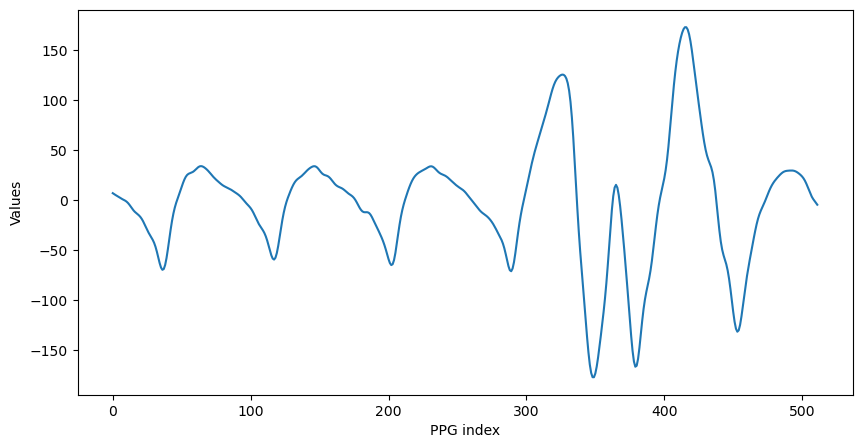

In [458]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ppg_graph.plot()
ax.set_xlabel('PPG index')
ax.set_ylabel('Values')
ax.tick_params('x')

In [460]:
import scipy as sp
from scipy.fft import fft, fftfreq, rfft, rfftfreq

In [462]:
np_ppg_arr = np.array(ppg_graph)
np_ppg_arr = np_ppg_arr
len(np_ppg_arr)

512

In [464]:
# fft() calculates the transform itself.

# fftfreq() calculates the frequencies in the center of each bin in the output of fft(). Without this, there would be no way to plot the x-axis on your frequency spectrum.
ppg_fft = fft(np_ppg_arr)

In [466]:
len(ppg_fft), ppg_fft

(512,
 array([-1.11400000e+03-0.00000000e+00j, -3.53292892e+02-1.06358696e+03j,
         9.77601574e+02+8.70089095e+02j, -3.03488010e+03+2.15506628e+03j,
        -2.32318428e+03-4.86579446e+03j,  6.96688836e+03-3.03942158e+03j,
         5.18888409e+03+1.39048540e+04j, -1.98774888e+03+1.64721130e+03j,
        -1.27983575e+03+1.05056206e+03j, -4.62587770e+03-1.55806575e+03j,
         1.23483509e+03-6.23768301e+03j,  4.76426104e+03+2.11365394e+03j,
        -2.91479602e+03-1.53058895e+02j, -1.92255539e+03-2.96321759e+03j,
         2.62706383e+03+4.49114661e+02j, -1.15865587e+03+2.81758278e+03j,
        -1.74472372e+03-8.78718844e+02j,  1.53314056e+03-7.28788800e+02j,
        -1.29760698e+03+2.56956952e+03j, -1.27349693e+03-8.67577636e+02j,
         9.02545823e+02-1.49864156e+03j,  1.32299707e+03-1.03118037e+01j,
         4.21329097e+02+5.56674219e+02j, -7.95748650e+02+3.01979565e+02j,
         5.49038744e+02-6.07945417e+02j, -3.59192154e+01-3.99052136e+02j,
        -4.09269383e+02+1.609824

In [468]:
ppg_fft

array([-1.11400000e+03-0.00000000e+00j, -3.53292892e+02-1.06358696e+03j,
        9.77601574e+02+8.70089095e+02j, -3.03488010e+03+2.15506628e+03j,
       -2.32318428e+03-4.86579446e+03j,  6.96688836e+03-3.03942158e+03j,
        5.18888409e+03+1.39048540e+04j, -1.98774888e+03+1.64721130e+03j,
       -1.27983575e+03+1.05056206e+03j, -4.62587770e+03-1.55806575e+03j,
        1.23483509e+03-6.23768301e+03j,  4.76426104e+03+2.11365394e+03j,
       -2.91479602e+03-1.53058895e+02j, -1.92255539e+03-2.96321759e+03j,
        2.62706383e+03+4.49114661e+02j, -1.15865587e+03+2.81758278e+03j,
       -1.74472372e+03-8.78718844e+02j,  1.53314056e+03-7.28788800e+02j,
       -1.29760698e+03+2.56956952e+03j, -1.27349693e+03-8.67577636e+02j,
        9.02545823e+02-1.49864156e+03j,  1.32299707e+03-1.03118037e+01j,
        4.21329097e+02+5.56674219e+02j, -7.95748650e+02+3.01979565e+02j,
        5.49038744e+02-6.07945417e+02j, -3.59192154e+01-3.99052136e+02j,
       -4.09269383e+02+1.60982422e+02j, -5.19729986

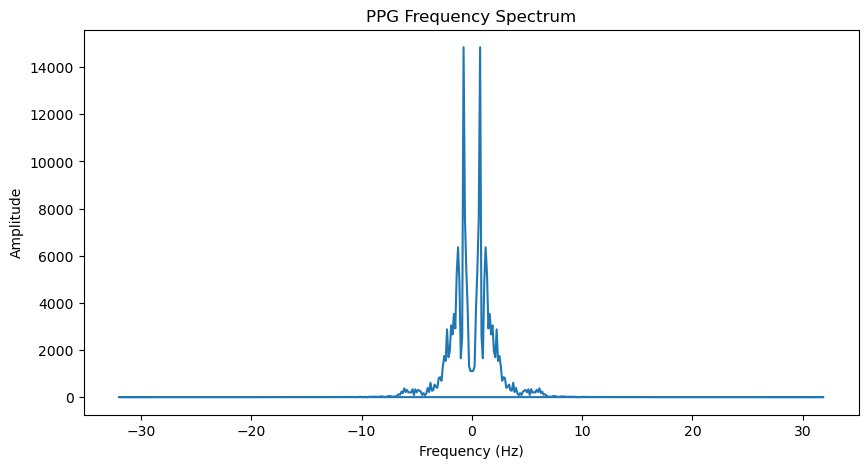

In [470]:
from scipy.fft import fft, fftfreq

np_ppg_arr = np.array(ppg_graph)
ppg_fft = fft(np_ppg_arr)
SAMPLE_RATE = 64  # Hertz
DURATION = 8  # Seconds
N = len(np_ppg_arr)

ppg_freq = fftfreq(N, 1/SAMPLE_RATE)

# Plot only the positive frequencies
plt.figure(figsize=(10, 5))
plt.plot(ppg_freq, np.abs(ppg_fft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('PPG Frequency Spectrum')
plt.show()


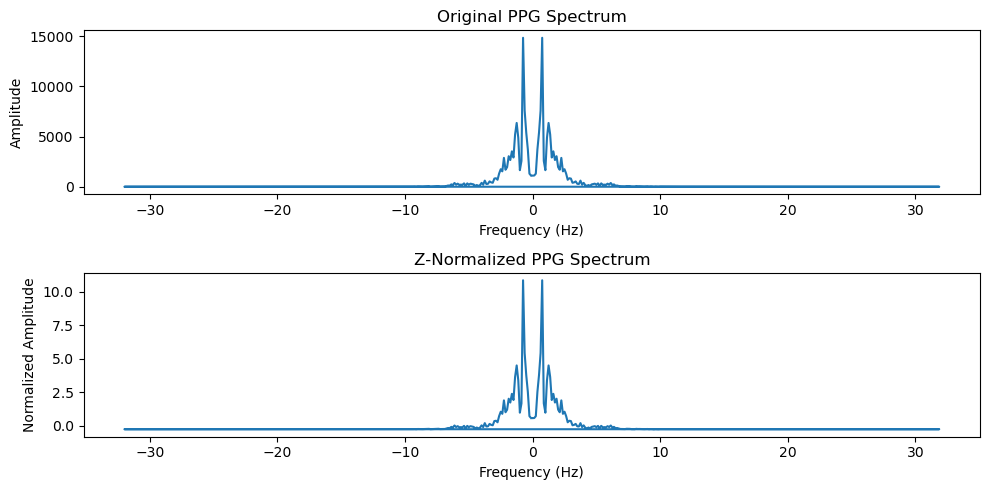

In [472]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Assuming you already have the frequency spectrum np.abs(ppg_fft)
# Replace this with your actual data
np_ppg_arr = np.array(ppg_graph)
ppg_fft = fft(np_ppg_arr)
SAMPLE_RATE = 64  # Hertz
DURATION = 8  # Seconds
N = len(np_ppg_arr)

ppg_mean = np.mean(np.abs(ppg_fft))
ppg_std = np.std(np.abs(ppg_fft))
ppg_normalized = (np.abs(ppg_fft) - ppg_mean) / ppg_std


plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(ppg_freq, np.abs(ppg_fft))
plt.title('Original PPG Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(ppg_freq, ppg_normalized)
plt.title('Z-Normalized PPG Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Amplitude')

plt.tight_layout()
plt.show()


In [474]:
mean_normalized = np.mean(ppg_normalized)
std_normalized = np.std(ppg_normalized)
mean_normalized, std_normalized

(0.0, 1.0)